# TO DO

1. Analyze the proportion of posts by (texts, pictures, other external links).
2. Calculate the boxplot in terms of scores with the categories above.
3. Check the number of authors with more than 1 post/10 karma gains.
4. Plot out the possibility of popular posts by hours.


In [1]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

In [2]:
conn = sqlite3.connect('redditPosts.sqlite')
cur = conn.cursor()

In [3]:
cur.execute('''SELECT subreddit FROM Posts
                GROUP BY subreddit''')

subreddits = list(map(lambda x: x[0],cur.fetchall()))
subreddits

['CryptoCurrency',
 'GME',
 'Superstonks',
 'dogecoin',
 'finance',
 'options',
 'pennystocks',
 'wallstreetbets']

In [11]:
cur.execute('''SELECT COUNT(*) FROM Posts
                WHERE subreddit = "pennystocks" AND (ext_link LIKE "%png" OR ext_link LIKE "%jpg")  ''')

cur.fetchone()[0]

5618

In [26]:
def getProportionOfPosts(cursor, subreddit):
    cur.execute('''SELECT COUNT(*) FROM Posts
                WHERE subreddit = ? AND (ext_link LIKE "%png" OR ext_link LIKE "%jpg")  ''', (subreddit,))
    pictures = cur.fetchone()[0]
    
    cur.execute('''SELECT COUNT(*) FROM Posts
                WHERE subreddit = ? AND ext_link LIKE "%/r/%"  ''', (subreddit,))
    
    no_links = cur.fetchone()[0]
    
    cur.execute('''SELECT COUNT(*) FROM Posts
                WHERE subreddit = ? ''', (subreddit,))
    total = cur.fetchone()[0]
    
    others = total - pictures - no_links
    
    #print(f'There are {pictures} posts with pictures and {total} posts in total. Thus, {pictures/total} of all posts in {subreddit} are pictures.')
    
    return pictures, others, total


getProportionOfPosts(cur,'GME')


(41489, 18245, 145611)

In [11]:
ratios = []

for subreddit in subreddits:
    pic, _, total = getProportionOfPictures(cur,subreddit)
    ratios.append(pic/total)



(0.0, 1.0)

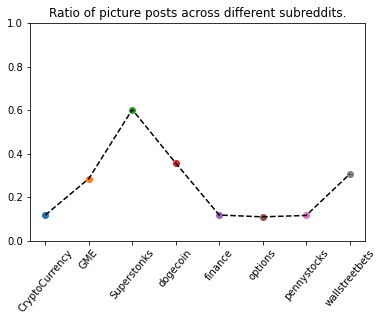

In [22]:
for i,(ratio, subreddit) in enumerate(zip(ratios,subreddits)):
    plt.scatter(i,ratio)
plt.plot(ratios, 'k--')
#plt.legend()
plt.xticks(range(8), subreddits,rotation=50)
plt.title('Ratio of picture posts across different subreddits.')
plt.ylim((0,1))

In [32]:
def getScoreDistribution(cursor, subreddit):
    
    cur.execute('''SELECT B.score, (CASE
                                WHEN (P.ext_link LIKE "%png" OR P.ext_link LIKE "%jpg") THEN 1
                                WHEN (P.ext_link LIKE "%/r/%") THEN 2
                                ELSE 3
                                END) FROM
                    (SELECT id, ext_link FROM Posts WHERE subreddit == ?) P
                    JOIN
                    (SELECT id, score FROM PostBodyAndScore) B
                    ON P.id = B.id''',(subreddit,))
    
    Scores = cur.fetchall()

    pic, text, links = [],[],[]

    for score, cat in Scores:
        if cat == 1:
            pic.append(score)
        elif cat == 2:
            text.append(score)
        else:
            links.append(score)
    
    
    return pic,text,links
    

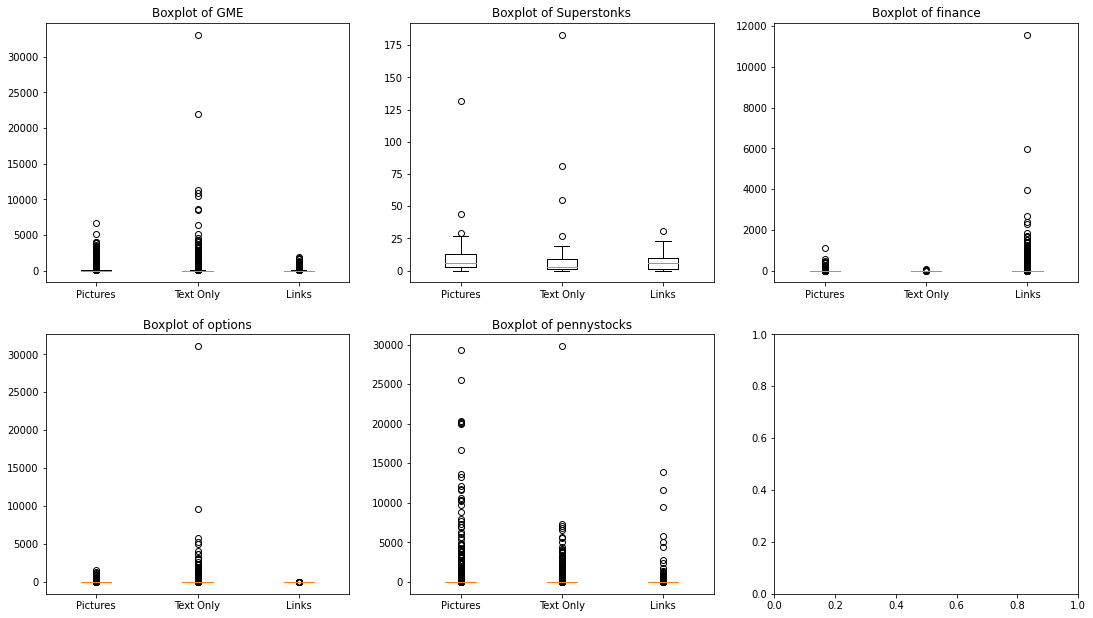

In [80]:
subredditsWithScores = ['GME','Superstonks','finance','options','pennystocks']

subreddit = 'finance'

fig, axes = plt.subplots(2,3)

axs = axes.ravel()

for i,subreddit in enumerate(subredditsWithScores):

    Scores = getScoreDistribution(cur, subreddit)


    axs[i].boxplot(Scores, labels = ["Pictures", "Text Only", "Links"])
    axs[i].title.set_text(f'Boxplot of {subreddit}')

fig.set_size_inches(18.5, 10.5)
#plt.legend()
#plt.xlim((500,50000))

In [18]:

def numActiveAuthors(subreddit, threshold):

    cur.execute('''SELECT COUNT(author)
                    FROM (SELECT author, COUNT(id) AS cnt FROM (SELECT author, id FROM Posts WHERE subreddit = ?)
                            GROUP BY author)
                    WHERE cnt >= ?''',(subreddit,threshold))
    
    actives = cur.fetchone()[0]
    
    cur.execute('''SELECT COUNT(DISTINCT author)
                    FROM Posts
                    WHERE subreddit = ?''',(subreddit,))
    
    total = cur.fetchone()[0]
    
    return actives, total


In [19]:
threshold = 5
for subreddit in subreddits:
    print(subreddit,numActiveAuthors(subreddit, threshold))

CryptoCurrency (4726, 84948)
GME (6908, 40526)
Superstonks (2, 64)
dogecoin (24848, 169071)
finance (54, 1267)
options (339, 10251)
pennystocks (1514, 24938)
wallstreetbets (26334, 499428)


In [22]:
proportions = np.zeros((len(subreddits),10))

for i,subreddit in enumerate(subreddits):
    for j,threshold in enumerate(range(1,11)):
        actives, total = numActiveAuthors(subreddit, threshold)
        proportions[i,j] = actives/total


<Figure size 1440x1440 with 0 Axes>

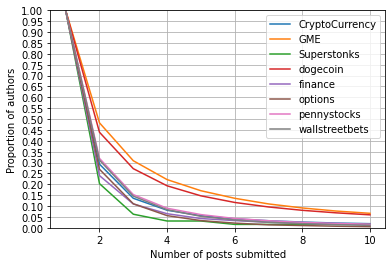

<Figure size 1440x1440 with 0 Axes>

In [33]:
for i,subreddit in enumerate(subreddits):
    plt.plot(range(1,11), proportions[i,:], label = subreddit)
plt.legend()
plt.grid()
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,21))
plt.xlabel("Number of posts submitted")
plt.ylabel("Proportion of authors")
plt.figure(figsize=(20,20))


In [3]:
def getMeanScoreWithActiveAuthor(subreddit, threshold):
    cur.execute('''SELECT AVG(B.score) AS mean_score, COUNT(P.id) as cnt FROM (
                        (SELECT * FROM Posts WHERE subreddit = ?) P
                        JOIN PostBodyAndScore B
                        ON P.id = B.id)
                        GROUP BY P.author''', (subreddit,))
    
    aboveThreshold = []
    belowThreshold = []
    
    for mean_score, count in cur.fetchall():
        if count >= threshold:
            aboveThreshold.append(mean_score)
        else:
            belowThreshold.append(mean_score)
    
    return (aboveThreshold, belowThreshold)



In [4]:
subredditsWithScores = ['GME','Superstonks','finance','options','pennystocks']
scoreList = []
threshold = 5

for subreddit in subredditsWithScores:
    scoreList.append(getMeanScoreWithActiveAuthor(subreddit, threshold))

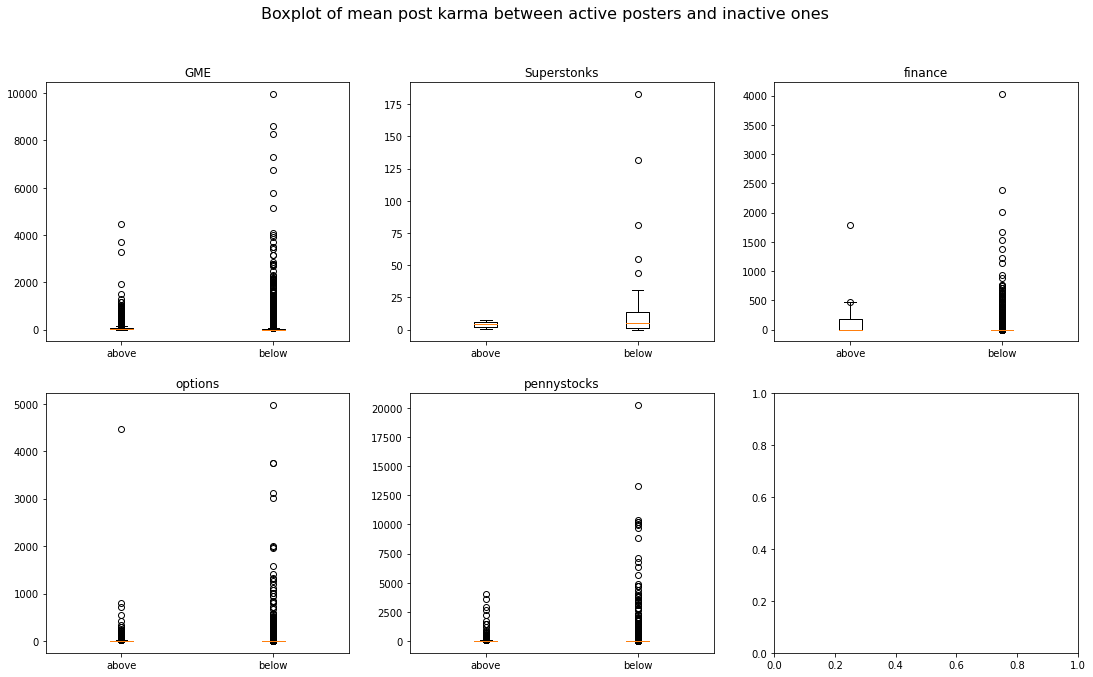

In [65]:
fig, axes =plt.subplots(2,3)
axs = axes.ravel()
fig.set_size_inches(18.5, 10.5)
fig.suptitle('Boxplot of mean post karma between active posters and inactive ones', fontsize=16)
for i,subreddit in enumerate(subredditsWithScores):
    
    axs[i].boxplot(scoreList[i],labels = ['above', 'below'])
    axs[i].title.set_text(subreddit)

In [52]:
len(scoreList[0])

2

In [54]:
def getMaxScoreWithActiveAuthor(subreddit, threshold):
    cur.execute('''SELECT MAX(B.score) AS mean_score, COUNT(P.id) as cnt FROM (
                        (SELECT * FROM Posts WHERE subreddit = ?) P
                        JOIN PostBodyAndScore B
                        ON P.id = B.id)
                        GROUP BY P.author''', (subreddit,))
    
    aboveThreshold = []
    belowThreshold = []
    
    for mean_score, count in cur.fetchall():
        if count >= threshold:
            aboveThreshold.append(mean_score)
        else:
            belowThreshold.append(mean_score)
    
    return (aboveThreshold, belowThreshold)

In [60]:
subredditsWithScores = ['GME','Superstonks','finance','options','pennystocks']
scoreList = []
threshold = 5

for subreddit in subredditsWithScores:
    scoreList.append(getMaxScoreWithActiveAuthor(subreddit, threshold))

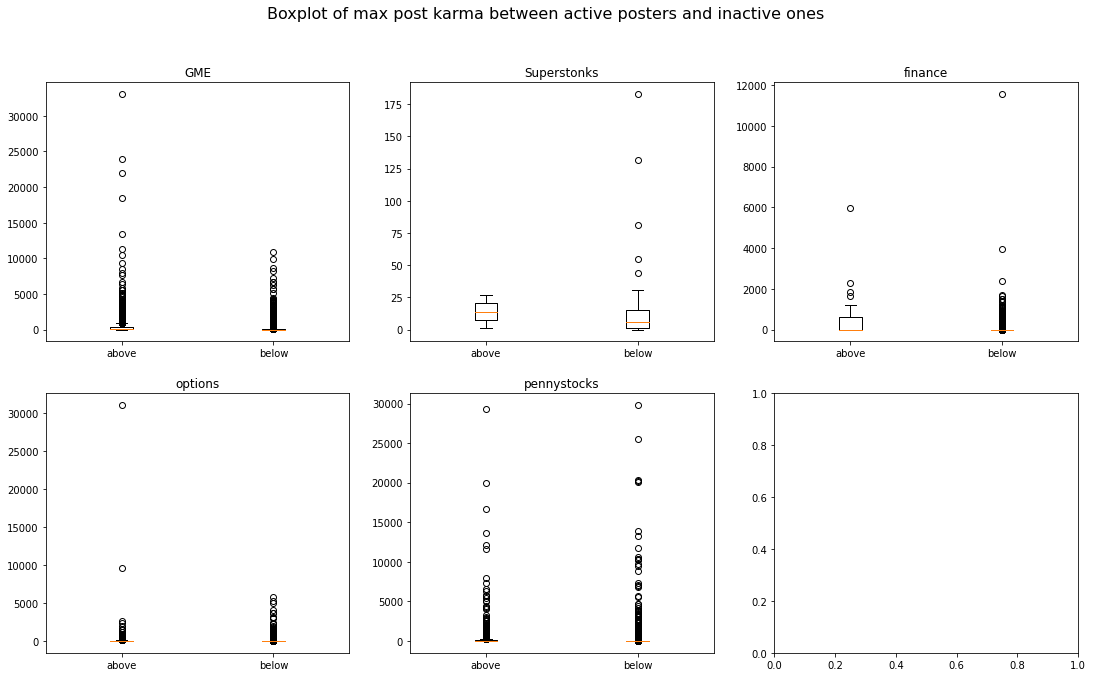

In [58]:
fig, axes =plt.subplots(2,3)
axs = axes.ravel()
fig.set_size_inches(18.5, 10.5)
fig.suptitle('Boxplot of max post karma between active posters and inactive ones', fontsize=16)
for i,subreddit in enumerate(subredditsWithScores):
    
    axs[i].boxplot(scoreList[i],labels = ['above', 'below'])
    axs[i].title.set_text(subreddit)

1

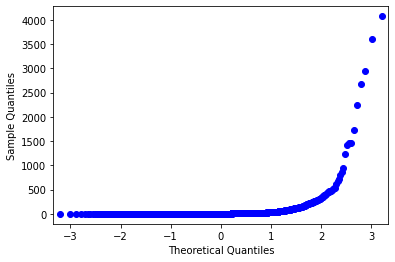

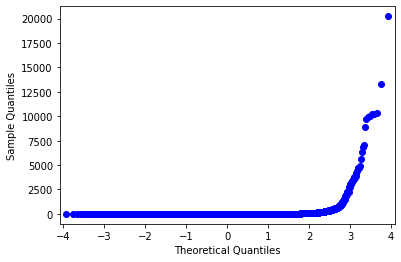

In [20]:
import statsmodels.api as sm

sm.qqplot(np.array(scoreList[4][0]))
sm.qqplot(np.array(scoreList[4][1]))
1

In [11]:
scoreList[0][0]

[16.5,
 51.4,
 19.36842105263158,
 34.294117647058826,
 36.0,
 34.8,
 19.4,
 359.57142857142856,
 86.0,
 171.58823529411765,
 11.8,
 25.6875,
 216.58333333333334,
 52.714285714285715,
 39.77777777777778,
 484.9166666666667,
 476.0,
 24.8,
 41.8768115942029,
 0.4,
 43.09090909090909,
 106.65384615384616,
 31.055555555555557,
 62.5,
 20.0,
 775.8,
 59.6,
 27.2,
 7.625,
 3.3333333333333335,
 65.0,
 1.6666666666666667,
 11.066666666666666,
 43.5,
 39.4,
 20.896551724137932,
 56.0,
 13.166666666666666,
 23.333333333333332,
 22.8,
 167.0,
 114.78125,
 533.25,
 11.928571428571429,
 42.4375,
 8.416666666666666,
 17.857142857142858,
 109.0,
 12.88888888888889,
 10.5,
 22.814814814814813,
 3.1538461538461537,
 8.8,
 517.2,
 1322.2,
 138.33333333333334,
 64.0,
 7.2,
 5.6,
 17.666666666666668,
 30.2,
 12.75,
 6.8,
 989.8666666666667,
 36.375,
 10.714285714285714,
 9.2,
 69.14285714285714,
 62.0,
 34.68421052631579,
 47.57142857142857,
 19.8,
 37.357142857142854,
 4.375,
 168.0909090909091,
 10.0,


In [22]:
import datetime as dt

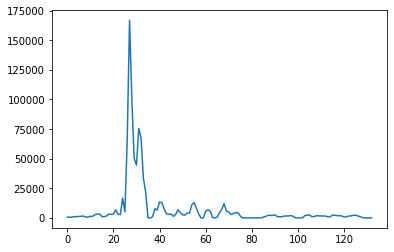

In [28]:
subreddit = 'wallstreetbets'
start = dt.datetime(2021,1,1).timestamp()
end = dt.datetime(2021,5,15).timestamp()

totalDays = (int(end)-int(start))//86400
postNums = [0]*totalDays


cur.execute('''SELECT created FROM Posts
                WHERE subreddit = ?''', (subreddit,))



for created in cur.fetchall():
    day = int(created[0] - starting)//86400
    postNums[day] += 1

plt.plot(postNums)